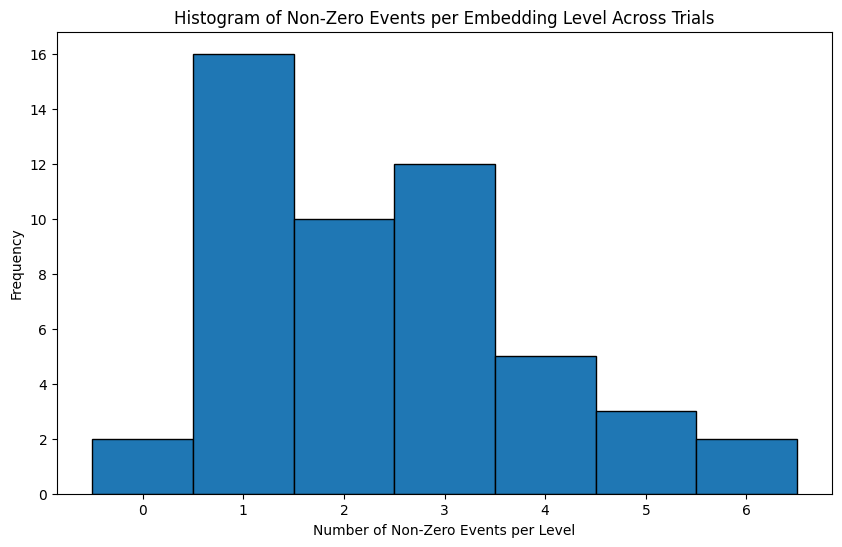

Empirical Mutual Information between Embedding Levels and Neural Events: 0.0002 bits
Normalized Mutual Information: 0.0003


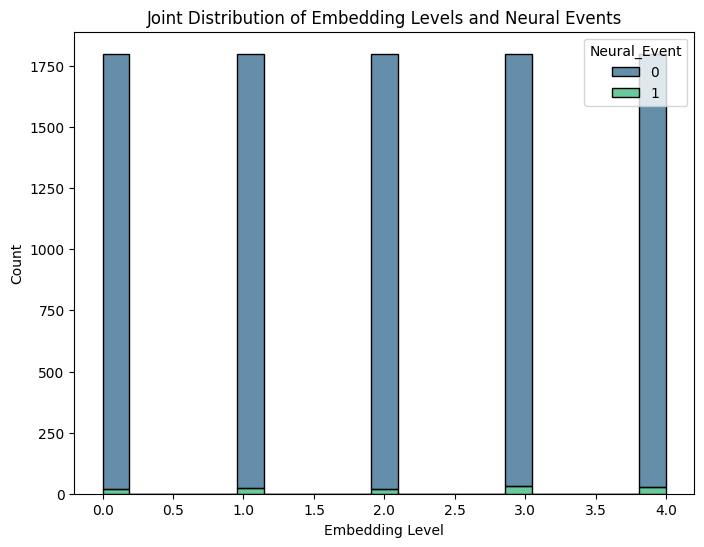

In [1]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle
from sklearn.metrics import mutual_info_score

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

stimuli = transfr['natural_movie_one']

# Specify the experiment ID
experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')

def generate_event_count_vector_levels(trial_ind, neuron_ind, transformer_emb_ind):
    ts = stim_table[stim_table['repeat'] == trial_ind]['start'].values
    neuron = data_set_events[neuron_ind, ts]
    embeddings = stimuli[:, transformer_emb_ind]
    
    # Partition the embeddings into 5 levels based on quantiles
    quantiles = np.percentile(embeddings, [20, 40, 60, 80])
    bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
    levels = np.digitize(embeddings, bins) - 1 

    event_values_per_level = []
    for level in range(5):
        indices = np.where(levels == level)[0]
        event_values = neuron[indices]
        event_values_per_level.append(event_values)

    event_values_per_level = np.array(event_values_per_level)
    event_values_nonzero = np.count_nonzero(event_values_per_level, axis=1)

    return event_values_nonzero

# Existing code to collect neuron trial counts
neuron_trial_counts = []

for trial in range(10):
    neuron_trial_counts.append(generate_event_count_vector_levels(trial, 6, 0))

neuron_trial_counts = np.array(neuron_trial_counts)

plt.figure(figsize=(10, 6))
plt.hist(neuron_trial_counts.flatten(), bins=range(neuron_trial_counts.max()+2), align='left', edgecolor='black')
plt.xlabel('Number of Non-Zero Events per Level')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Events per Embedding Level Across Trials')
plt.show()

# --------------------------------------------------------------
# New Code to Calculate Empirical Mutual Information
# --------------------------------------------------------------

# Initialize lists to store levels and event presence
levels_list = []
events_list = []

def collect_levels_and_events(trial_ind, neuron_ind, transformer_emb_ind):
    ts = stim_table[stim_table['repeat'] == trial_ind]['start'].values
    neuron = data_set_events[neuron_ind, ts]
    embeddings = stimuli[:, transformer_emb_ind]
    
    # Partition the embeddings into 5 levels based on quantiles
    quantiles = np.percentile(embeddings, [20, 40, 60, 80])
    bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
    levels = np.digitize(embeddings, bins) - 1  # Levels 0 to 4

    for level, event in zip(levels, neuron):
        levels_list.append(level)
        # Assuming event is binary; if not, convert to binary
        events_list.append(1 if event > 0 else 0)

# Define parameters
num_trials = 10  # Adjust based on your data
neuron_index = 6  # As used in your existing code
transformer_emb_index = 0  # As used in your existing code

# Collect data across all trials
for trial in range(num_trials):
    collect_levels_and_events(trial, neuron_index, transformer_emb_index)

# Convert lists to numpy arrays for consistency (optional)
levels_array = np.array(levels_list)
events_array = np.array(events_list)

# Compute Mutual Information
mi = mutual_info_score(levels_array, events_array)

print(f"Empirical Mutual Information between Embedding Levels and Neural Events: {mi:.4f} bits")

# Optional: Normalize Mutual Information
# Mutual information can be normalized to [0, 1] by dividing by the entropy of the variables
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(levels_array, events_array)
print(f"Normalized Mutual Information: {nmi:.4f}")

# Optional: Visualize the Joint Distribution
import seaborn as sns
import pandas as pd

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Embedding_Level': levels_array,
    'Neural_Event': events_array
})

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Embedding_Level', hue='Neural_Event', multiple='stack', palette='viridis')
plt.xlabel('Embedding Level')
plt.ylabel('Count')
plt.title('Joint Distribution of Embedding Levels and Neural Events')
plt.show()
